In [1]:
pwd

'/home/prajwal/Desktop/Winter_Project/SLP-Smoothed-Particle-Hydrodynamics/SLP/Taylor Green Vortex'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})


In [2]:
nx, perturb = 30, 0
nx, perturb = str(int(nx)), str(int(perturb))

file_base = '/home/prajwal/Desktop/Winter_Project/SLP-Smoothed-Particle-Hydrodynamics/SLP/Taylor Green Vortex/Output/'
file_base += 'nx_' + nx + '/perturb_' + perturb

## Plot decay

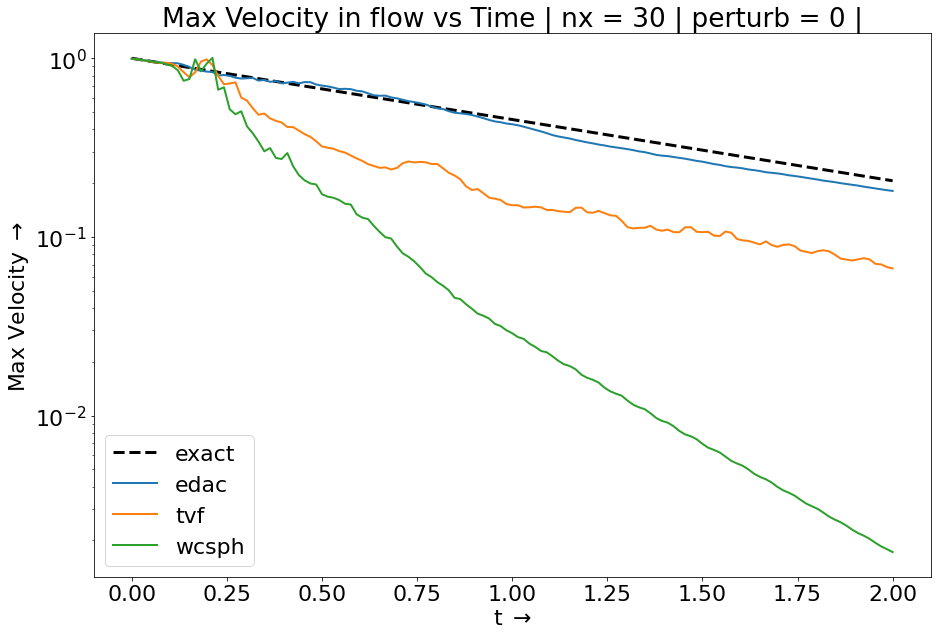

In [4]:
sz = (15,10)
plt.figure(figsize=sz)

for schm in ['edac', 'tvf', 'wcsph']:
    file_loc = file_base + '/' + schm + '/results.npz'
    # Read data
    data = np.load(file_loc)
    
    # Unpack
    t, decay, decay_ex = data['t'], data['decay'], data['decay_ex']
    
    # Plot
    if schm == 'edac':
        plt.semilogy(t, decay_ex, '--k', linewidth=3, label="exact")
    plt.semilogy(t, decay, linewidth=2, label=schm)
    
# Formatting    
plt.xlabel(r't $\rightarrow$')
plt.ylabel(r'Max Velocity $\rightarrow$')
tle = 'Max Velocity in flow vs Time | nx = ' + nx + ' | perturb = ' + perturb + ' |'
plt.title(tle)
plt.legend()
tle = 'decay_' + nx + '.png' 
plt.savefig(tle, dpi=400)

## Plot L_{\infty} error

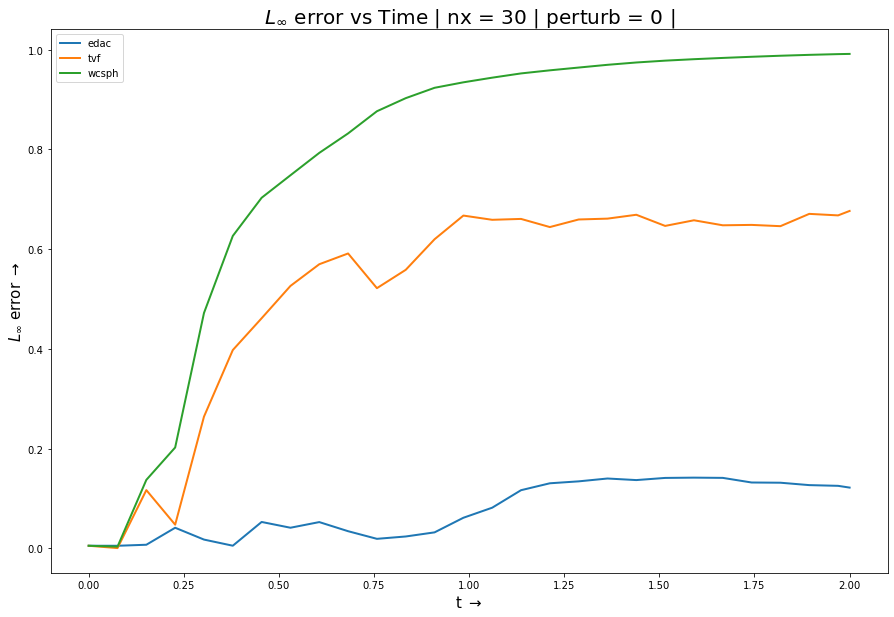

In [107]:
sz = (15,10)
plt.figure(figsize=sz)

for schm in ['edac', 'tvf', 'wcsph']:
    file_loc = file_base + '/' + schm + '/results.npz'
    # Read data
    data = np.load(file_loc)
    
    # Unpack
    t, linf = data['t'], data['linf']
    
    # Plot
    plt.plot(t, linf, linewidth=2, label=schm)
    
# Formatting
plt.xlabel(r't $\rightarrow$',fontsize=15)
plt.ylabel(r'$L_\infty$ error $\rightarrow$',fontsize=15)
tle = r'$L_\infty$ error vs Time | nx = ' + nx + ' | perturb = ' + perturb + ' |'
plt.title(tle,fontsize=20)
plt.legend()
tle = 'linf_error_' + nx + '.png' 
plt.savefig(tle, dpi=400)

## Plot L_1 error

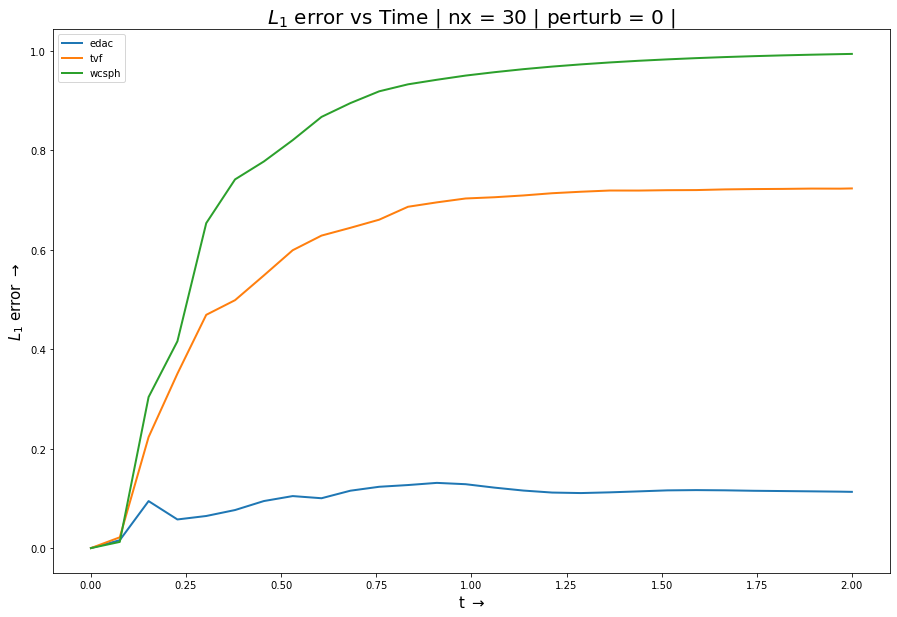

In [109]:
sz = (15,10)
plt.figure(figsize=sz)

for schm in ['edac', 'tvf', 'wcsph']:
    file_loc = file_base + '/' + schm + '/results.npz'
    # Read data
    data = np.load(file_loc)
    
    # Unpack
    t, l1 = data['t'], data['l1']
    
    # Plot
    plt.plot(t, l1,linewidth=2, label=schm)
    
# Formatting
plt.xlabel(r't $\rightarrow$',fontsize=15)
plt.ylabel(r'$L_1$ error $\rightarrow$',fontsize=15)
tle = r'$L_1$ error vs Time | nx = ' + nx + ' | perturb = ' + perturb + ' |'
plt.title(tle,fontsize=20)
plt.legend()
tle = 'l1_error_' + nx + '.png' 
plt.savefig(tle, dpi=400)

## Plot L_1 error for p

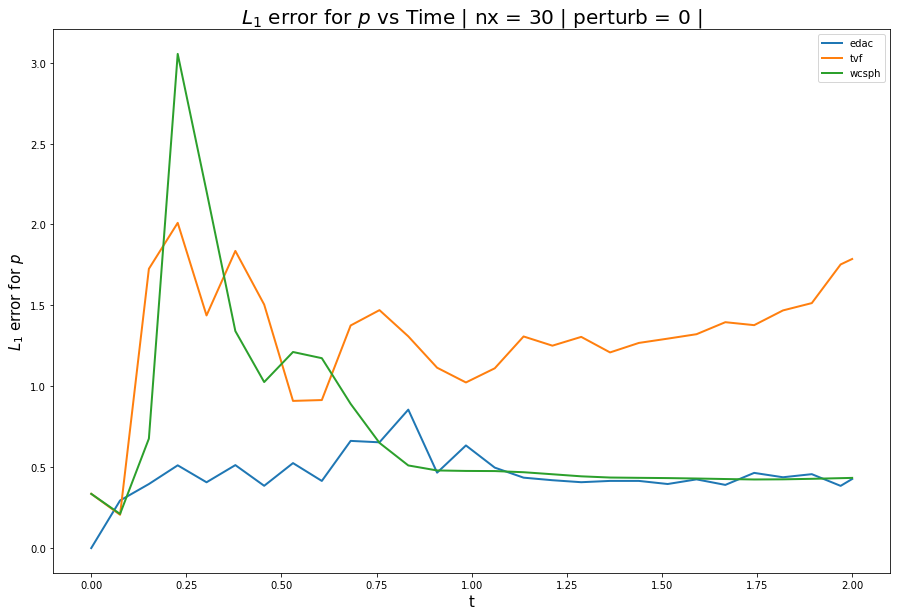

In [110]:
sz = (15,10)
plt.figure(figsize=sz)

for schm in ['edac', 'tvf', 'wcsph']:
    file_loc = file_base + '/' + schm + '/results.npz'
    # Read data
    data = np.load(file_loc)
    
    # Unpack
    t, p_l1 = data['t'], data['p_l1']
    
    # Plot
    plt.plot(t, p_l1,linewidth=2, label=schm)
    
# Formatting
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$L_1$ error for $p$',fontsize=15)
tle = r'$L_1$ error for $p$ vs Time | nx = ' + nx + ' | perturb = ' + perturb + ' |'
plt.title(tle,fontsize=20)
plt.legend()
tle = 'p_l1_error_' + nx + '.png' 
plt.savefig(tle, dpi=400)

In [3]:
nx_low = [54.58, 38.81, 31.11, 35.25]
nx_high = [98.9, 126.99, 78.52, 97.91]
x_ax = ['dpsph', 'edac', 'tvf', 'wcsph']

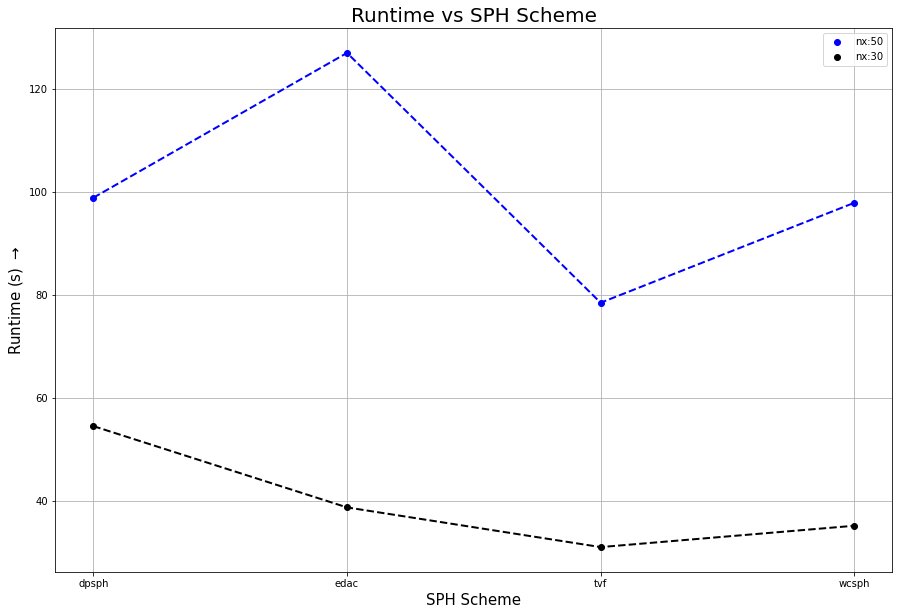

In [20]:
sz = (15,10)
plt.figure(figsize=sz)
plt.plot(x_ax, nx_high, 'ob',linewidth=2, label='nx:50')
plt.plot(x_ax, nx_high, '--b',linewidth=2)
plt.plot(x_ax, nx_low, 'ok', linewidth=2, label='nx:30')
plt.plot(x_ax, nx_low, '--k', linewidth=2)
# Formatting
plt.xlabel('SPH Scheme',fontsize=15)
plt.ylabel(r'Runtime (s) $\rightarrow$',fontsize=15)
tle = r'Runtime vs SPH Scheme'
plt.title(tle,fontsize=20)
plt.legend()
plt.grid()